# RoadMap 17 - Classification 4 - Transfer learning [Custom Dataset, Learning Rate Scheduler, Model saver]

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Steps to take

1. Create a network
    - Creating base network
    - Visualize layers
    - Creating loss function module
    - Creating optimizer module [Set learning rates here]
    - Creating learning rate scheduler
    
    
2. Data prepraration
    - Creating a data transformer
    - Downloading and storing dataset
    - Applying transformation
    - Understanding dataset
    - Loading the transformed dataset [Set batch size and number of parallel processors here]
    
    
3. Setting up data - plotters


4. Training
    - Set Epoch
    - Train model
    
    
5. Testing
    - Just after training
    - After loading saved weights


In [5]:
# 1.1 Creating base model

model_ft = models.resnet18(pretrained=True) # Using pretrained models
num_ftrs = model_ft.fc.in_features # Adding a new layer to next final layer
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# 1.2 Visualizing network
from torchsummary import summary
print("Network - ")
summary(model_ft, (3, 224, 224))

Network - 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14        

In [7]:
# 1.3. Creating loss function module
cross_entropy_loss = nn.CrossEntropyLoss()

In [8]:
# 1.4. Creating optimizer module
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [9]:
# 1.5. Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
# 2.1. Creating data trasnformer

# A dictionary of transformers
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### 2.2 Storing downloaded dataset


    Data storage directory 
        [NOTE: Directory and File names can be anything]
        Parent Directory [hymenoptera_data]
            |
            |----Train
            |       |
            |       |----Class1 [car]
            |       |       |----img1.png
            |       |       |----img2.png
            |       |----Class2 [dog]
            |       |       |----img1.png
            |               |----img2.png
            |-----Val
            |       |
            |       |----Class1 [cat]
            |       |       |----img1.png
            |       |       |----img2.png
            |       |----Class2 [dog]
            |       |       |----img1.png
            |       |       |----img2.png

In [14]:
# 2.2. Applying transformations simultaneously
data_dir = 'cat_dog/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}



In [16]:
# 2.3. - Understanding dataset
print("Total number of training images: ", len(image_datasets['train'].imgs))
print("Total number of validation images: ", len(image_datasets['val'].imgs))

Total number of training images:  200
Total number of validation images:  50


In [17]:
# 2.4. - Loading the transformed dataset

batch = 4
parallel_processors = 3

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch,
                                             shuffle=True, num_workers=parallel_processors)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

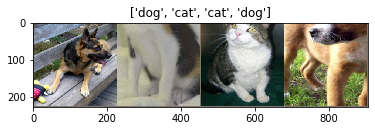

In [18]:
# 3. Setting up data plotters
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [24]:
# 4. Training


'''
Training pipeline
'''


# Create training pipeline
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # A shallow copy constructs a new compound object and then (to the extent possible) inserts 
    #    references into it to the objects found in the original. 
    # A deep copy constructs a new compound object and then, recursively, inserts copies into it of 
    #    the objects found in the original.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    torch.save(model.state_dict(), "cat_dog_model")
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_ft = train_model(model_ft, cross_entropy_loss, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3058 Acc: 0.8750
val Loss: 0.0218 Acc: 1.0000

Epoch 1/4
----------
train Loss: 0.3423 Acc: 0.8600
val Loss: 0.0172 Acc: 1.0000

Epoch 2/4
----------
train Loss: 0.3144 Acc: 0.8750
val Loss: 0.0223 Acc: 1.0000

Epoch 3/4
----------
train Loss: 0.3552 Acc: 0.8650
val Loss: 0.0167 Acc: 1.0000

Epoch 4/4
----------
train Loss: 0.2977 Acc: 0.8950
val Loss: 0.0206 Acc: 1.0000

Training complete in 0m 7s
Best val Acc: 1.000000


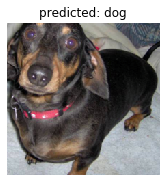

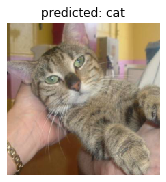

In [22]:
# 5.1. Testing - Just after training 
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
visualize_model(model_ft, num_images=2)

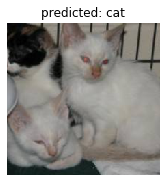

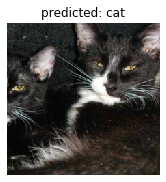

In [27]:
# 5.2. Testing - After loading weights

model_new = models.resnet18(pretrained=True) # Using pretrained models
num_ftrs = model_new.fc.in_features # Adding a new layer to next final layer
model_new.fc = nn.Linear(num_ftrs, 2)
model_new.load_state_dict(torch.load("cat_dog_model"))
model_new.cuda()

visualize_model(model_new, num_images=2)


## Author - Tessellate Imaging - https://www.tessellateimaging.com/

## Monk Library - https://github.com/Tessellate-Imaging/monk_v1

    Monk is an opensource low-code tool for computer vision and deep learning

### Monk features
- low-code
- unified wrapper over major deep learning framework - keras, pytorch, gluoncv
- syntax invariant wrapper


### Enables
- to create, manage and version control deep learning experiments
- to compare experiments across training metrics
- to quickly find best hyper-parameters


### At present it only supports transfer learning, but we are working each day to incorporate
- GUI based custom model creation
- various object detection and segmentation algorithms
- deployment pipelines to cloud and local platforms
- acceleration libraries such as TensorRT
- preprocessing and post processing libraries

## To contribute to Monk AI or Pytorch RoadMap repository raise an issue in the git-repo or dm us on linkedin 
 - Abhishek - https://www.linkedin.com/in/abhishek-kumar-annamraju/
 - Akash - https://www.linkedin.com/in/akashdeepsingh01/